In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
def landslide_classification(target, train_size=.7):
    """
    input:
        target : str : variable to predict
            available targets: landslide, mudslide, complex, rock_fall,
            debris_flow, riverbank_collapse, other, unknown, lahar,
            snow_avalanche, creep, earth_flow, translational_slide, topple
        train_size : float : size of training set < 1; default = .7
    output:
        cm : plot : confusion matrix of classification
    """
    # load data
    data = pd.read_csv(
        "https://data.nasa.gov/api/views/dd9e-wu2v/rows.csv?accessType=DOWNLOAD"
    )

    # clean whitespace from columns
    data.columns = data.columns.str.strip()

    # get dummies for target variable
    dum = pd.get_dummies(data["landslide_category"])
    new_df = data.join(dum)

    # clean new_df
    new_df = new_df.select_dtypes(exclude="object")
    new_df = new_df.drop(
        columns=["event_id", "event_time", "longitude", "latitude", "event_import_id"],
        axis=1,
    )
    new_df = new_df.dropna()

    # set x and y values
    X = new_df[["fatality_count", "injury_count"]]
    y = new_df[target]

    # split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=1
    )

    # build Random Forest Classifier params for GridSearchCV
    rfc = RandomForestClassifier()
    params = {
        "n_estimators": [100, 1000, 1500],
        "criterion": ["gini", "entropy"],
        "max_depth": [1, 5, 10],
        "max_features": ["auto", "sqrt", "log2"],
        "n_jobs": [-1],
        "random_state": [1],
    }

    # Build GridSearchCV
    grid = GridSearchCV(rfc, params).fit(X_train, y_train)
    grid_df = pd.DataFrame(grid.cv_results_)

    # Find best model
    best_model = grid_df.loc[:"mean_test_score"].max()

    # Train best model
    best_rfc = RandomForestClassifier(
        n_estimators=best_model.param_n_estimators,
        criterion=best_model.param_criterion,
        max_depth=best_model.param_max_depth,
        max_features=best_model.param_max_features,
        n_jobs=best_model.param_n_jobs,
        random_state=best_model.param_random_state,
    ).fit(X_train, y_train)

    y_pred = best_rfc.predict(X)

    # get results
    con_mat = confusion_matrix(y, y_pred)
    accuracy = np.trace(con_mat) / np.sum(con_mat).astype("float")
    misclassified = 1 - accuracy

    ax = plt.subplot()
    sns.heatmap(con_mat, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(label=target + " Confusion Matrix")
    plt.xlabel(
        "Predicted\naccuracy={:0.4f}; misclassified={:0.4f}".format(
            accuracy, misclassified
        )
    )
    plt.ylabel("True")
    ax.xaxis.set_ticklabels(["Positive", "Negative"])
    ax.yaxis.set_ticklabels(["Positive", "Negative"])

    return plt.show()

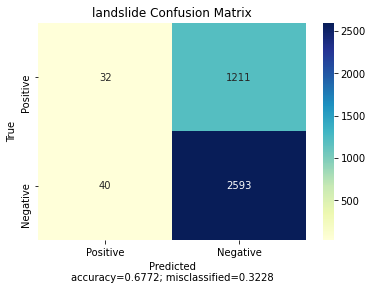

In [3]:
landslide_classification(target="landslide", train_size=.3)